In [2]:
from pipeline.Pipeline import Load
import pandas as pd


load_df = Load()

final_df = load_df.load_restaraunts() 


from datetime import datetime


import pandas as pd
current_date = datetime.now()
dia = current_date.day
month = current_date.month
year = current_date.year
hour = current_date.hour
min = current_date.minute
csv_name = f'dataframe{dia}-{month}-{year}AT{hour}:{min}.csv'

#final_df = pd.read_csv('dataframe4-12-2024AT22:20.csv')
df =final_df
df.to_csv(csv_name,index=True)







Dados sendo carregados


In [3]:


# Filtrar os dados onde is_deleted == 0
restaurantes_nao_deletados = final_df[final_df['is_deleted'] == 0]

# Selecionar 200 amostras aleatórias
amostras_selecionadas = restaurantes_nao_deletados.sample(n=25, random_state=7891)

# Salvar essas amostras em um CSV, se necessário
amostras_selecionadas.to_csv('amostras_teste.csv', index=False)

print(f"Número de amostras selecionadas: {len(amostras_selecionadas)}")

final_df = final_df.drop(amostras_selecionadas.index)

Número de amostras selecionadas: 25


Número de outliers (survival_days): 82


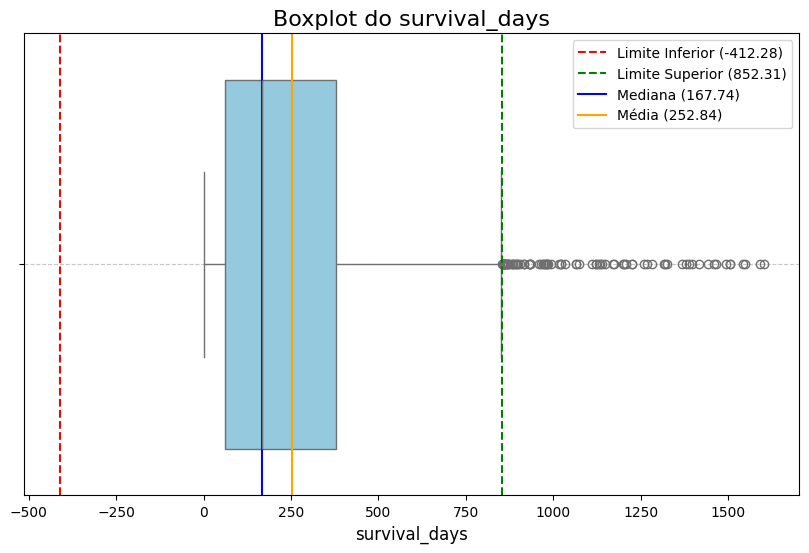

                      fantasy_name          survival_days
5                     Rei do Peixe  1603.2885400341898148
8                        Pop Motel   964.8849977314814815
10                       Top Sushi  1591.9789825110416667
16                      Taberna 91  1549.4019781013194444
17                  Caffè Lorenzon  1543.3593925804861111
..                             ...                    ...
286  Tribbu Coqueiral de Itaparica   857.3728118513194444
287              Palácio da Esfiha   857.1408584485416667
288                       TRINOFIT   856.9007341661342593
289                         Oishi    856.4489554508564815
291                   Tipiti Motel   852.9593133790972222

[82 rows x 2 columns]
Média dos Outliers em anos :3.00
Média dos Outliers em dias :1094.65


In [9]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dados de mrr
survival_days_data = final_df['survival_days'].fillna(0).astype(float)

# Cálculos de estatísticas
q1 = np.percentile(survival_days_data, 25)
q3 = np.percentile(survival_days_data, 75)
iqr = q3 - q1
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr
outliers = final_df[(final_df['survival_days'].astype(float) < limite_inferior) | (final_df['survival_days'].astype(float) > limite_superior)]

print(f"Número de outliers (survival_days): {len(outliers)}")
# Plot do boxplot usando seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=survival_days_data, color='skyblue')

# Adicionando anotações sobre limites
plt.axvline(x=limite_inferior, color='red', linestyle='--', label=f"Limite Inferior ({limite_inferior:.2f})")
plt.axvline(x=limite_superior, color='green', linestyle='--', label=f"Limite Superior ({limite_superior:.2f})")
plt.axvline(x=np.median(survival_days_data), color='blue', linestyle='-', label=f"Mediana ({np.median(survival_days_data):.2f})")
plt.axvline(x=np.mean(survival_days_data), color='orange', linestyle='-', label=f"Média ({np.mean(survival_days_data):.2f})")

# Configuração do gráfico
plt.title("Boxplot do survival_days", fontsize=16)
plt.xlabel("survival_days", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(outliers[['fantasy_name','survival_days']])
print(f'Média dos Outliers em anos :{np.mean(outliers[['survival_days']])/365:.2f}')
print(f'Média dos Outliers em dias :{np.mean(outliers[['survival_days']]):.2f}')

In [10]:




df = pd.DataFrame(final_df)





In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer



In [12]:


features_to_impute = [
 'has_club', 'has_ifood',
       'is_multistore_related', 'has_fiscal', 'only_delivery',
       'sessions_count', 'mrr', 'total_users', 'soma_ult_sem', 'soma_sem_anterior',
       'soma_2_sem_anteriores', 'variance_x', 'std_dev_x', 'comandas_ult_sem',
       'comandas_sem_anterior', 'comandas_2_sem_anteriores', 'variance_y',
       'std_dev_y', 'average_table_session'
]
missing_values = df[features_to_impute].isnull().sum()

missing_values



has_club                        0
has_ifood                       0
is_multistore_related           0
has_fiscal                      0
only_delivery                   0
sessions_count                  0
mrr                          1169
total_users                     0
soma_ult_sem                  503
soma_sem_anterior             503
soma_2_sem_anteriores         503
variance_x                    503
std_dev_x                     503
comandas_ult_sem              503
comandas_sem_anterior         503
comandas_2_sem_anteriores     503
variance_y                    503
std_dev_y                     503
average_table_session        1071
dtype: int64

In [16]:
imputer = SimpleImputer()

X_to_impute = df[features_to_impute]
X_imputed = imputer.fit_transform(X_to_impute)




y_time = df['survival_days'].astype(float)  # Tempo até o evento
y_event = df['is_deleted'].astype(bool)    # Churn ocorreu ou não

scaler = StandardScaler()
X_scaled=scaler.fit_transform(X_imputed)

In [17]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw
from sklearn.model_selection import train_test_split

In [18]:



y = Surv.from_arrays(event=y_event, time=y_time)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,  
    y,        
    test_size=0.5,  
    random_state=42,  
    stratify=y_event 
)







rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=20,max_depth=10, random_state=42)


rsf.fit(X_train, y_train)


c_index_train = rsf.score(X_train, y_train)  # Avaliar no conjunto de treino
c_index_test = rsf.score(X_test, y_test)    # Avaliar no conjunto de teste

print(f"C-Index no conjunto de treino: {c_index_train}")
print(f"C-Index no conjunto de teste: {c_index_test}")



C-Index no conjunto de treino: 0.8807555666655305
C-Index no conjunto de teste: 0.8389410761666628


In [19]:
from sklearn.model_selection import KFold
from sksurv.metrics import concordance_index_censored

# Configurar a validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_index_scores = []

for train_idx, test_idx in kf.split(X_scaled):
    # Dividir os dados
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Treinar o modelo
    rsf.fit(X_train, y_train)
    
    # Fazer previsões e calcular o C-Index
    surv_preds = rsf.predict_survival_function(X_test)
    c_index = rsf.score(X_test, y_test)
    c_index_scores.append(c_index)

# Resultado médio da validação cruzada
print(f"C-Index médio: {np.mean(c_index_scores):.4f}")


C-Index médio: 0.8448


\begin{aligned} c = \dfrac{\sum_{i \neq j} 1 \{ \eta_i < \eta_j \} 1 \{ T_i > T_j \} d_j }{\sum_{i \neq j} 1 \{ T_i > T_j \} d_j }. \end{aligned}



# Componentes

𝑖
e
𝑗 
representam dois restaurantes.

Estamos analisando todos os pares possíveis (
𝑖
≠
𝑗
).

1{𝜂
𝑖
​
 <𝜂 
𝑗
​
 }: Indica que o escore predito η para o restaurante 
𝑖
 é menor que o de 
𝑗
. 

1{T𝑖>T 𝑗}: Indica que o tempo observado 
𝑇
para 
𝑖
 é maior que o de 
𝑗
. Isso reflete a ordem verdadeira dos tempos de sobrevivência.

d 
𝑗
​
 : Indicador de censura. Vale 1 se o evento ocorreu para 
𝑗
, ou seja, 
𝑗
 não é censurado. Isso garante que apenas pares não censurados sejam usados no cálculo.


# Numerador:

 Soma de todas as comparações concordantes entre os pares 
𝑖
,
𝑗
. Concordância ocorre quando a previsão 
𝜂
𝑖

​
  e a realidade 
𝑇
𝑖
estão alinhadas.

# Denominador
Soma de todos os pares ordenáveis, ou seja, pares onde 
𝑇𝑖>𝑇𝑗  e o evento para 
𝑗
 foi observado (
𝛿
𝑗 =1).






# De maneira simplificada

\begin{aligned} c = \dfrac{\# \text{ concordant pairs}}{\# \text{ concordant pairs} + \# \text{ discordant pairs}}. \end{aligned}


In [26]:
from sksurv.metrics import brier_score

import numpy as np

surv_funcs = rsf.predict_survival_function(X_test)


y_test_structured = np.array(

    [(event, time) for event, time in y_test],
    dtype=[("event", bool), ("time", float)]

)



y_train_structured = np.array(

    [(event, time) for event, time in y_train],
    dtype=[("event", bool), ("time", float)]
)



time_horizons = np.arange(1,1500,30)
surv_probs = np.array([[fn(t) for t in time_horizons] for fn in surv_funcs ])


        


# Calcular o Brier Score
times, brier_scores = brier_score(y_train_structured, y_test_structured, surv_probs, time_horizons)


print(np.mean(brier_scores))

0.09689266496534027


$$
BS^c(t) = \frac{1}{n} \sum_{i=1}^{n} \left[ \mathbb{I}(y_i \leq t \land \delta_i = 1) \frac{(0 - \hat{\pi}(t \mid \mathbf{x}_i))^2}{\hat{G}(y_i)} + \mathbb{I}(y_i > t) \frac{(1 - \hat{\pi}(t \mid \mathbf{x}_i))^2}{\hat{G}(t)} \right]
$$


n: Número total de observações.

𝐼(⋅): Função indicadora que retorna 1 se a condição for verdadeira e 0 caso contrário.

𝑦𝑖: Tempo de sobrevivência do restaurante 𝑖

𝛿𝑖: Indicador de censura para o indivíduo 𝑖(1 se o evento ocorreu, 0 se censurado).

𝜋^(𝑡∣𝑥𝑖): Probabilidade predita de sobrevivência até o tempo 𝑡 para o indivíduo 𝑖, 
dado seu vetor de características 𝑥𝑖.

𝐺^(𝑡): Estimativa da função de distribuição acumulada de Kaplan-Meier no tempo 𝑡, 
representando a probabilidade de não censura até 𝑡.

O termo é ajustado pela estimativa de censura 𝐺^(𝑦𝑖), que controla para os indivíduos censurados no conjunto de dados.


O 𝐵𝑆𝑐(𝑡)
 mede o quão bem o modelo prevê a probabilidade de sobrevivência ao longo do tempo 
𝑡. Um valor próximo de 0 indica boas previsões, enquanto valores maiores sugerem erros significativos nas previsões.

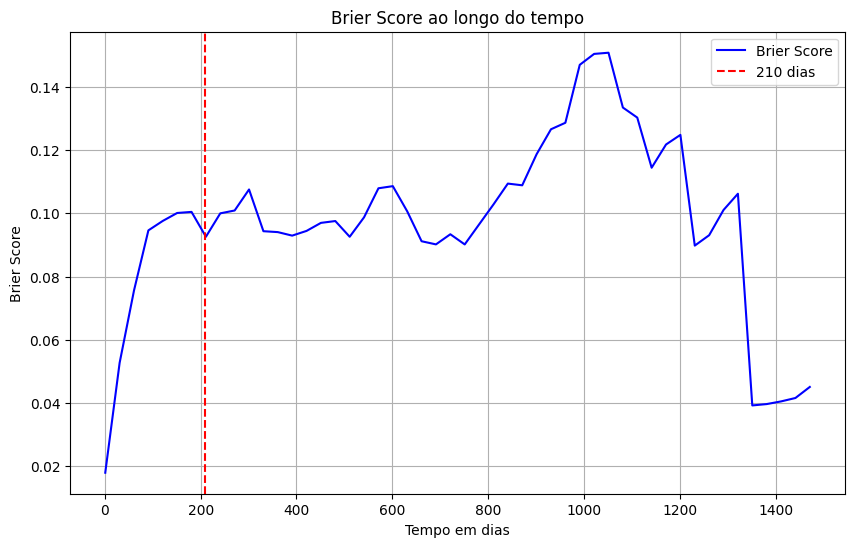

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(times, brier_scores, label="Brier Score", color="blue")
plt.axvline(x=210, color="red", linestyle="--", label="210 dias")
plt.xlabel("Tempo em dias")
plt.ylabel("Brier Score")
plt.title("Brier Score ao longo do tempo")
plt.legend()
plt.grid()
plt.show()


Estatistica Ifood: 88.2281467660627
P-value Ifood: 5.832405213689901e-21
Estatistica Clube: 63.046188148264754
P-value Clube: 2.0191576320994976e-15
Há uma diferença estatisticamente significativa entre os grupos(CLUBE).
Há uma diferença estatisticamente significativa entre os grupos(IFOOD).


/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/home/miguel/Documentos/churn_model/ml_churn_model/lib/python3.12/site-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually conver

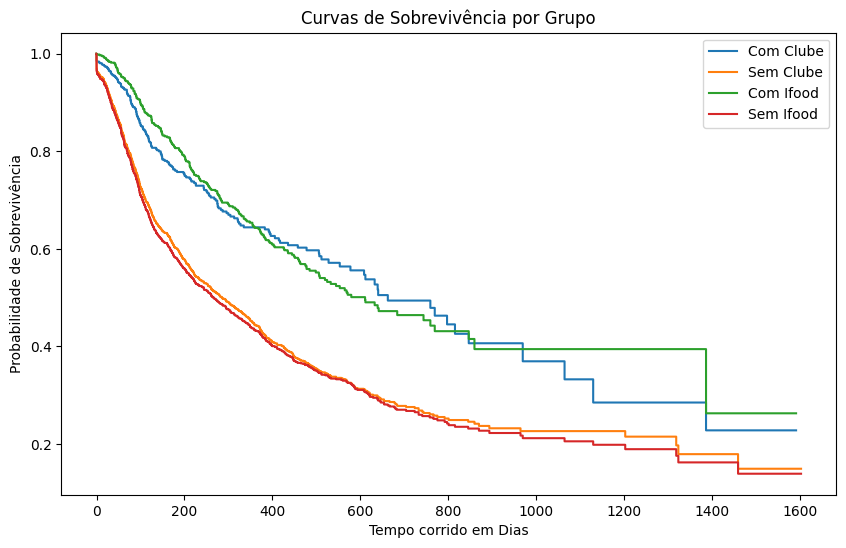

In [28]:
from lifelines.statistics import KaplanMeierFitter,logrank_test

clientes_clube = df[df['has_club']==1]
clientes_sem_clube = df[df['has_club']==0]
clientes_ifood = df[df['has_ifood'] == 1]
clientes_sem_ifood = df[df['has_ifood']==0]

results_clube = logrank_test(clientes_clube['survival_days'].astype(float),
                       clientes_sem_clube['survival_days'].astype(float),
                       event_observed_A=clientes_clube['is_deleted'],
                       event_observed_B=clientes_sem_clube['is_deleted']
                       
                       )

results_ifood = logrank_test(clientes_ifood['survival_days'].astype(float),
                       clientes_sem_ifood['survival_days'].astype(float),
                       event_observed_A=clientes_ifood['is_deleted'],
                       event_observed_B=clientes_sem_ifood['is_deleted'])



print(f'Estatistica Ifood: {results_ifood.test_statistic}')
print(f'P-value Ifood: {results_ifood.p_value}')

print(f'Estatistica Clube: {results_clube.test_statistic}')
print(f'P-value Clube: {results_clube.p_value}')



if results_clube.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(CLUBE).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(CLUBE).")


if results_ifood.p_value < 0.05:
    print("Há uma diferença estatisticamente significativa entre os grupos(IFOOD).")
else:
    print("Não há diferença estatisticamente significativa entre os grupos(IFOOD).")


kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))


kmf.fit(clientes_clube['survival_days'], event_observed=clientes_clube['is_deleted'], label="Com Clube")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_clube['survival_days'], event_observed=clientes_sem_clube['is_deleted'], label="Sem Clube")
kmf.plot_survival_function(ci_show = False)


kmf.fit(clientes_ifood['survival_days'], event_observed=clientes_ifood['is_deleted'], label="Com Ifood")
kmf.plot_survival_function(ci_show = False)

kmf.fit(clientes_sem_ifood['survival_days'], event_observed=clientes_sem_ifood['is_deleted'], label="Sem Ifood")
kmf.plot_survival_function(ci_show = False)

plt.title("Curvas de Sobrevivência por Grupo")
plt.xlabel("Tempo corrido em Dias")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()
plt.show()

  

# Kapplan - Meier

O Kaplan-Meier é uma técnica usada para estimar a função de sobrevivência em dados de sobrevivência. A função de sobrevivência, 
𝑆
(
𝑡
), mede a probabilidade de um restaurante "sobreviver" além de um tempo 𝑡.

$$
\hat{S}(t) = \prod_{t_i \leq t} \left( 1 - \frac{d_i}{n_i} \right)
$$


𝑡𝑖:Tempo de um evento observado (cancelamento).

𝑑𝑖:Número de eventos no tempo 𝑡𝑖.

𝑛𝑖:Número de indivíduos em risco imediatamente antes do tempo 𝑡𝑖.

# Log-Rank


$$
\chi^2 = \frac{\left(\sum_{i} (O_i - E_i)\right)^2}{\sum_{i} V_i}
$$


𝑂𝑖:Número de eventos observados no grupo 𝑖.

𝐸𝑖:Número de eventos esperados no grupo 𝑖, dado o tamanho do grupo e a função de sobrevivência geral.

𝑉𝑖:Variância da diferença (𝑂𝑖−𝐸𝑖).

Essa estatística segue uma distribuição qui-quadrado (𝜒^2) com 𝑘−1 graus de liberdade, onde 𝑘 é o número de grupos.

Como funciona:
Para cada tempo 𝑡𝑖 onde ocorre um evento, calcula-se o número esperado de eventos em cada grupo com base no número total de indivíduos em risco naquele tempo.

Soma-se as diferenças entre o número observado e esperado para todos os tempos.

A estatística final verifica se as diferenças entre os grupos são grandes o suficiente para rejeitar a hipótese nula (que assume que as curvas de sobrevivência são iguais).